In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def generate_accuracy_and_heatmap(model, x, y):

    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)
    print ("\n")
    print (pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
                       pd.Series(y['Outcome'],name='Actual')))
    return 1

In [4]:
df = pd.read_csv('diabetes.csv')

In [5]:
df.shape

(768, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [9]:
df['BloodPressureSquare'] = np.square(df['BloodPressure'])
df['BloodPressureCube'] = df['BloodPressure']**3
df['BloodPressureSqrt'] = np.sqrt(df['BloodPressure'])

In [10]:
df['GlucoseSquare'] = np.square(df['Glucose'])
df['GlucoseCube'] = df['Glucose']**3
df['GlucoseSqrt'] = np.sqrt(df['Glucose'])

In [11]:
df['GlucoseBloodPressure'] = df['BloodPressure'] * df['Glucose']
df['AgeBMI'] = df['Age'] * df['BMI']

In [12]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  BloodPressureSquare  \
0                     0.627   50        1                 5184   
1                     0.351   31        0                 4356   
2                     0.672   32        1                 4096   
3                     0.167   21        0                 4356   
4                     2.288   33        1                 1600   

   BloodPressureCube  BloodPressureSqrt  GlucoseSquare  GlucoseCube  \
0             373248              8.485          21904      3241792   
1             287496              8.124           7225       614125   
2             262144              8.000          33489      6128487   
3             287496              8.124           7921       704969   
4              64000              6.325          18769      2571353   

   GlucoseSqrt  GlucoseBloodPressure   AgeBMI  
0       12.166                 10656 1680.000  
1        9.220                  5610  824.600  
2       13.528                 11712  745.600  
3        9.434                  5874  590.100  
4       11.705                  5480 1422.300

In [13]:
categorical_feature_columns = list(set(df.columns) - set(df._get_numeric_data().columns))
categorical_feature_columns

[]

In [14]:
numerical_feature_columns = list(df._get_numeric_data().columns)
numerical_feature_columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome',
 'BloodPressureSquare',
 'BloodPressureCube',
 'BloodPressureSqrt',
 'GlucoseSquare',
 'GlucoseCube',
 'GlucoseSqrt',
 'GlucoseBloodPressure',
 'AgeBMI']

In [15]:
target = 'Outcome'

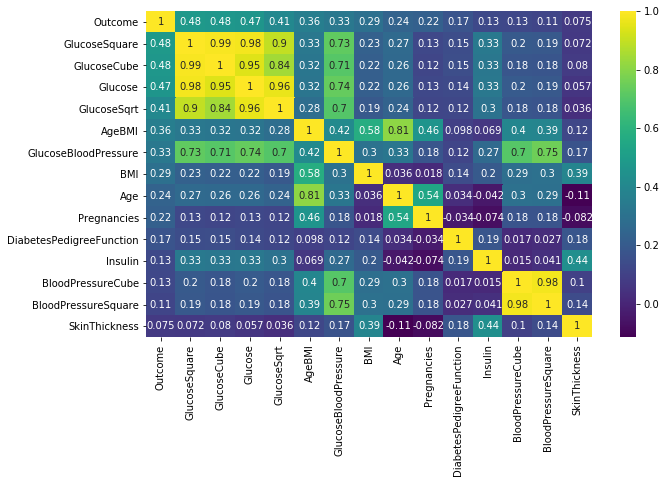

In [16]:
k = 15 #number of variables for heatmap
cols = df[numerical_feature_columns].corr().nlargest(k, target)[target].index
cm = df[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [17]:
X = df.loc[:, df.columns != target]
Y = df.loc[:, df.columns == target]

In [18]:
X.shape

(768, 16)

In [19]:
Y.shape

(768, 1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=8)

In [21]:
clf_lr = LogisticRegression()      
lr_baseline_model = clf_lr.fit(x_train,y_train)

In [22]:
generate_accuracy_and_heatmap(lr_baseline_model, x_test, y_test)

Accuracy is:  0.7598425196850394
F1 score is:  0.6013071895424835


Actual      0   1
Predicted        
0          39  23
1          15   8


1

## Univariate feature selection by SELECTKBEST

In [23]:
select_feature = SelectKBest(chi2, k=5).fit(x_train, y_train)

In [24]:
selected_features_df = pd.DataFrame({'Feature':list(x_train.columns),
                                     'Scores':select_feature.scores_})
selected_features_df.sort_values(by='Scores', ascending=False)

Feature        Scores
12               GlucoseCube 140493344.594
9          BloodPressureCube    916853.946
11             GlucoseSquare    474020.139
14      GlucoseBloodPressure     77960.489
15                    AgeBMI     10527.823
8        BloodPressureSquare      4333.499
4                    Insulin      1026.387
1                    Glucose       924.909
7                        Age        93.008
5                        BMI        71.933
0                Pregnancies        53.730
3              SkinThickness        47.760
13               GlucoseSqrt        20.700
2              BloodPressure         8.329
6   DiabetesPedigreeFunction         4.719
10         BloodPressureSqrt         0.043

In [25]:
x_train_chi = select_feature.transform(x_train)
x_test_chi = select_feature.transform(x_test)

In [26]:
x_train.head(3)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
60             2       84              0              0        0  0.000   
332            1      180              0              0        0 43.300   
421            2       94             68             18       76 26.000   

     DiabetesPedigreeFunction  Age  BloodPressureSquare  BloodPressureCube  \
60                      0.304   21                    0                  0   
332                     0.282   41                    0                  0   
421                     0.561   21                 4624             314432   

     BloodPressureSqrt  GlucoseSquare  GlucoseCube  GlucoseSqrt  \
60               0.000           7056       592704        9.165   
332              0.000          32400      5832000       13.416   
421              8.246           8836       830584        9.695   

     GlucoseBloodPressure   AgeBMI  
60                      0    0.000  
332                     0 1775.300  
421                  6392  546.000

In [27]:
x_train_chi[0:3]

array([[0.000e+00, 7.056e+03, 5.927e+05, 0.000e+00, 0.000e+00],
       [0.000e+00, 3.240e+04, 5.832e+06, 0.000e+00, 1.775e+03],
       [3.144e+05, 8.836e+03, 8.306e+05, 6.392e+03, 5.460e+02]])

In [28]:
lr_chi_model = clf_lr.fit(x_train_chi,y_train)

In [29]:
generate_accuracy_and_heatmap(lr_chi_model, x_test_chi, y_test)

Accuracy is:  0.7716535433070866
F1 score is:  0.6027397260273972


Actual      0   1
Predicted        
0          41  24
1          13   7


1

## Recursive Feature Elimination

In [30]:
rfe = RFE(estimator=clf_lr, step=1)
rfe = rfe.fit(x_train, y_train)

In [31]:
selected_rfe_features = pd.DataFrame({'Feature':list(x_train.columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

Feature  Ranking
0                Pregnancies        1
1                    Glucose        1
3              SkinThickness        1
5                        BMI        1
6   DiabetesPedigreeFunction        1
7                        Age        1
10         BloodPressureSqrt        1
13               GlucoseSqrt        1
4                    Insulin        2
2              BloodPressure        3
15                    AgeBMI        4
11             GlucoseSquare        5
14      GlucoseBloodPressure        6
8        BloodPressureSquare        7
9          BloodPressureCube        8
12               GlucoseCube        9

In [32]:
x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)

In [33]:
x_train_rfe[0:3]

array([[  2.   ,  84.   ,   0.   ,   0.   ,   0.304,  21.   ,   0.   ,
          9.165],
       [  1.   , 180.   ,   0.   ,  43.3  ,   0.282,  41.   ,   0.   ,
         13.416],
       [  2.   ,  94.   ,  18.   ,  26.   ,   0.561,  21.   ,   8.246,
          9.695]])

In [34]:
lr_rfe_model = clf_lr.fit(x_train_rfe, y_train)

In [35]:
generate_accuracy_and_heatmap(lr_rfe_model, x_test_rfe, y_test)

Accuracy is:  0.7874015748031497
F1 score is:  0.6582278481012658


Actual      0   1
Predicted        
0          37  24
1          17   7


1

## Recursive feature elimination with cross validation

In [36]:
rfecv = RFECV(estimator=clf_lr, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 9
Best features : Index(['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'BloodPressureSqrt', 'GlucoseSqrt'],
      dtype='object')


In [37]:
rfecv.grid_scores_

array([0.663, 0.724, 0.72 , 0.739, 0.755, 0.759, 0.755, 0.763, 0.77 ,
       0.768, 0.77 , 0.764, 0.761, 0.755, 0.764, 0.751])

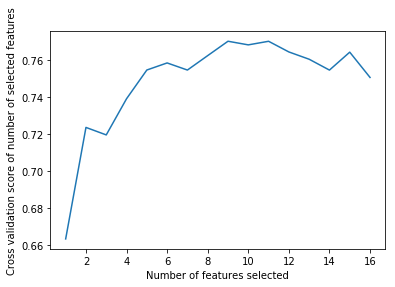

In [38]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [39]:
x_train_rfecv = rfecv.transform(x_train)
x_test_rfecv = rfecv.transform(x_test)

In [40]:
lr_rfecv_model = clf_lr.fit(x_train_rfecv, y_train)

In [41]:
generate_accuracy_and_heatmap(lr_rfecv_model, x_test_rfecv, y_test)

Accuracy is:  0.7874015748031497
F1 score is:  0.6582278481012658


Actual      0   1
Predicted        
0          37  25
1          17   6


1